In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [2]:
from osd import Problem
from osd.components import GaussNoise, LaplaceNoise, SmoothSecondDifference, \
    SmoothFirstDifference, SparseFirstDiffConvex, SparseSecondDiffConvex
from osd.utilities import progress

In [3]:
np.random.seed(42)
t = np.linspace(0, 1000, 3000)
c0 = 0.25 * np.random.randn(len(t))
c1 = signal.square(2 * np.pi / 300 * t)
c2 = 2 * np.abs(signal.sawtooth(2 * np.pi / 175 * t))
# c3 = 0.5 * (np.sin(2 * np.pi * t * 5 / (500.)) + np.cos(2 * np.pi * t * 7 / (550.)))
c3 = 0.5 * (np.sin(2 * np.pi * t * 5 / (500.)) + np.cos(2 * np.pi * t * 2.5 / (500.) - 50))
y = np.sum([c0, c1, c2, c3], axis=0)

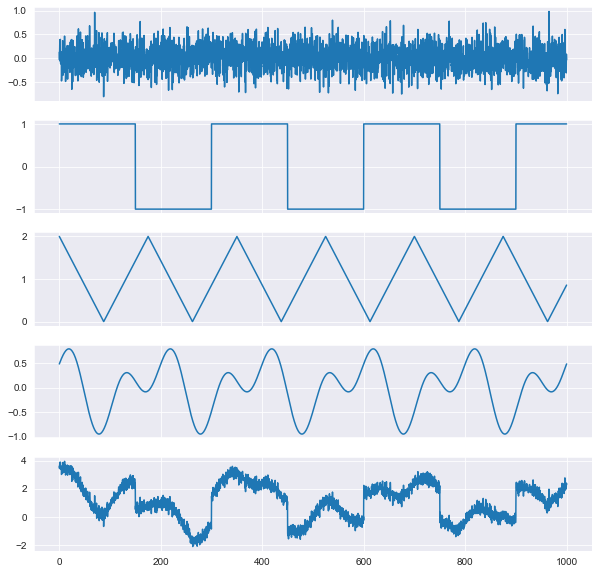

In [5]:
fig, ax = plt.subplots(nrows=5, sharex=True, sharey=False, figsize=(10, 10))
ax[0].plot(t, c0)
ax[1].plot(t, c1)
ax[2].plot(t, c2)
ax[3].plot(t, c3)
ax[4].plot(t, y)

## No periodicity information

In [6]:
components = [GaussNoise, SparseFirstDiffConvex(vmin=-1, vmax=1),
              SparseSecondDiffConvex(vmin=0, vmax=2),
              SmoothSecondDifference(vmin=-1, vmax=1)]
problem = Problem(data=y, components=components)

In [7]:
problem.weights.value = [1, 5, 20, 10000]

In [8]:
problem.demix(solver='MOSEK')

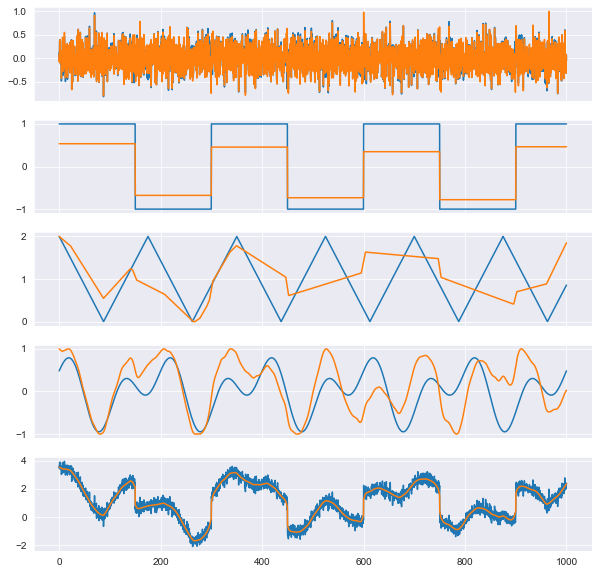

In [9]:
fig, ax = plt.subplots(nrows=5, sharex=True, sharey=False, figsize=(10, 10))
ax[0].plot(t, c0)
ax[0].plot(t, problem.estimates[0])
ax[1].plot(t, c1)
ax[1].plot(t, problem.estimates[1])
ax[2].plot(t, c2)
ax[2].plot(t, problem.estimates[2])
ax[3].plot(t, c3)
ax[3].plot(t, problem.estimates[3])
ax[4].plot(t, y)
ax[4].plot(t, problem.estimates[1] + problem.estimates[2] + problem.estimates[3])

## Include periodicity information

In [10]:
components = [GaussNoise, SparseFirstDiffConvex(vmin=-1, vmax=1),
              SparseSecondDiffConvex(vmin=0, vmax=2, period=175*3),
              SmoothSecondDifference(vmin=-1, vmax=1, period=600)]
problem = Problem(data=y, components=components)

In [11]:
problem.weights.value = [1, 5, 20, 10000]

In [12]:
problem.demix(solver='MOSEK')

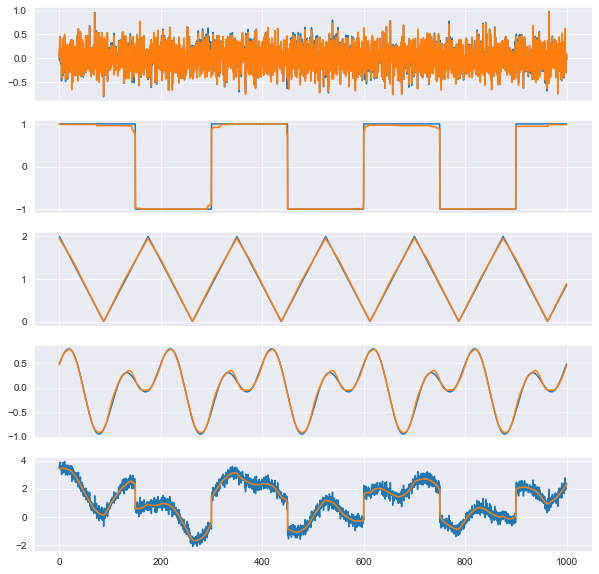

In [13]:
fig, ax = plt.subplots(nrows=5, sharex=True, sharey=False, figsize=(10, 10))
ax[0].plot(t, c0)
ax[0].plot(t, problem.estimates[0])
ax[1].plot(t, c1)
ax[1].plot(t, problem.estimates[1])
ax[2].plot(t, c2)
ax[2].plot(t, problem.estimates[2])
ax[3].plot(t, c3)
ax[3].plot(t, problem.estimates[3])
ax[4].plot(t, y)
ax[4].plot(t, problem.estimates[1] + problem.estimates[2] + problem.estimates[3])

In [14]:
param_search = np.logspace(-1, 5, 13)
nvals = len(param_search) ** 3
results = pd.DataFrame(columns=['w1', 'w2', 'w3', 'resid_cost'], index=range(nvals))
counter = 0
ti = time()
for w1 in param_search:
    for w2 in param_search:
        for w3 in param_search:
            tnow = time()
            msg = ' {:.2f} minutes'.format((tnow - ti) / 60.)
            progress(counter, nvals, msg)
            problem.weights.value = [1., w1, w2, w3]
            problem.demix(solver='MOSEK')
            results.loc[counter] = [w1, w2, w3, problem.holdout_validation(solver='MOSEK', seed=42)]
            counter += 1
tnow = time()
msg = ' complete, {:.2f} minutes'.format((tnow - ti) / 60.)
progress(counter, nvals, msg)
progress(counter, nvals)

In [15]:
results = results.astype(np.float)

In [16]:
results.loc[results['resid_cost'].idxmin()]

w1                 3.162278
w2                31.622777
w3            100000.000000
resid_cost        45.821953
Name: 584, dtype: float64

In [17]:
best = results.loc[results['resid_cost'].idxmin()]
problem.weights.value = [1., best['w1'], best['w2'], best['w3']]
problem.demix(solver='MOSEK')

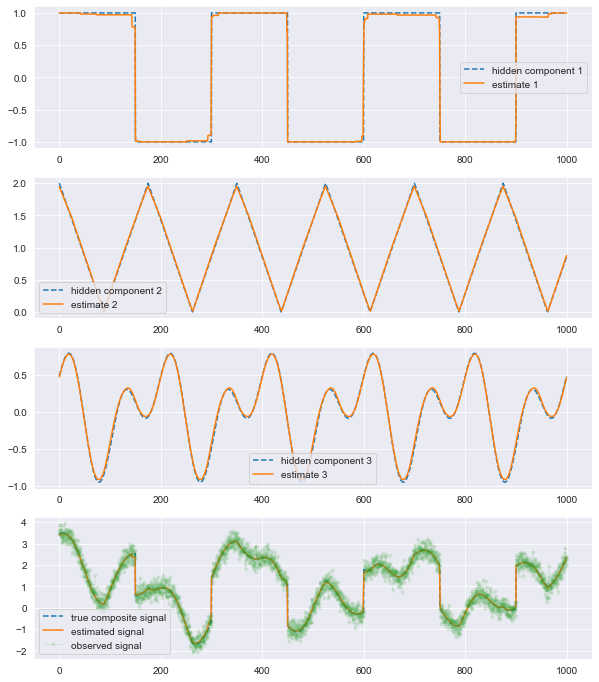

In [18]:
fig, ax = plt.subplots(nrows=4, figsize=(10, 12))
ax[0].plot(t, c1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='estimate 1')
ax[1].plot(t, c2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='estimate 2')
ax[2].plot(t, c3, label='hidden component 3', ls='--')
ax[2].plot(t, problem.estimates[3], label='estimate 3')
ax[3].plot(t, c1 + c2 + c3, label='true composite signal', ls='--')
ax[3].plot(t, problem.estimates[1] + problem.estimates[2] + problem.estimates[3], label='estimated signal');
ax[3].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()